In [27]:
import matplotlib.pyplot as plt
import numpy as np

In [28]:
# Real gas data from Wikipedia
labels = ["Hidrogenoa","Helioa","Nitrogenoa"]
latex = ["$H_2$", "$He$", "$N_2$"]
a_data = [24.7100, 3.4600, 137.00, 21.3500, 135.500, 1466.0, 820.000]
b_data = [0.02661, 0.0238, 0.0387, 0.01709, 0.03201, 0.1226, 0.01696]

In [29]:
# Parameters
i = 0 #Index to select a gas: 0-H2, 1-He, 2-N2
V = 1 #Volume in L
T_pt = 273.16 # Temperature in K
R = 8.31446 # Gas constant in L*kPa/K/mol

In [30]:
p_pt = np.linspace(1,120,120)

In [31]:
def get_n_values(p_pt,i):
    '''
    This function calculates the n values for
    every p_pt and gas i
    
    Inputs:
    p_pt: an array of the p_pt values (in kPa) on which we are calculating n
    i: integer index to characterize a gas
    '''
    a = a_data[i]
    b = b_data[i]
    n_values=[]
    for p in p_pt:
        poly = np.poly1d([a*b/V**3, -a/V, R*T_pt + p*b, -p*V])
        solutions = np.roots(poly) #This statement uses numpy roots to solve third order polynomial
        for sol in solutions: #This control seq. select the only real solution.
            if abs(sol.imag) < 1e-5:
                n_values.append(sol.real)
    return n_values

In [32]:
def get_p_values(n_values,i,T):
    '''
    This functions calculates the p values for
    every n in n_values, temperature T and gas i
    Temperature is represented in ideal gas scale
    '''
    a = a_data[i]
    b = b_data[i]
    p = []
    for n in n_values:
        p.append(n*R*T/(V-n*b)-a*n**2/V**2)
    return p

In [33]:
def get_empirical_temperature(p_pt,T,i):
    '''
    This functions calculates the empirical temperature of thermal state T
    for which p_pt and p have been previously calculated
    '''
    n_values = get_n_values(p_pt,i)
    p = get_p_values(n_values,i,T)
    theta = p/p_pt * 273.16
    return theta

In [34]:
#Empirical temperatures for NBP -> T=373.14K
T = 373.14
NBP=[0,0,0]
for i in range(len(labels)):
    NBP[i] = get_empirical_temperature(p_pt,T,i)

#Empirical temperatures for other point -> T=160.00K
T = 160.00
T_160 = [0,0,0]
for i in range(len(labels)):
    T_160[i] = get_empirical_temperature(p_pt,T,i)

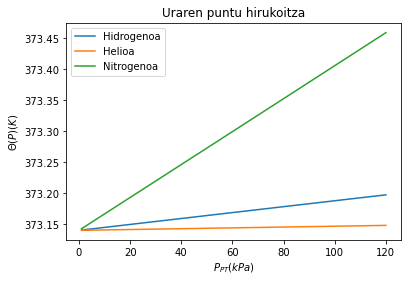

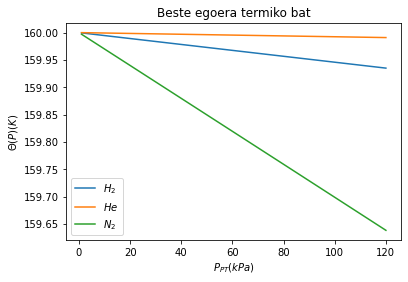

In [35]:
for i in range(len(labels)):
    plt.plot(p_pt, NBP[i], label=labels[i])
plt.xlabel('$P_{PT} (kPa)$')
plt.ylabel('$\Theta(P) (K)$')
plt.title('Uraren puntu hirukoitza')
plt.legend()
plt.show()

for i in range(len(labels)):
    plt.plot(p_pt, T_160[i], label=latex[i])
plt.xlabel('$P_{PT} (kPa)$')
plt.ylabel('$\Theta(P) (K)$')
plt.title('Beste egoera termiko bat')
plt.legend()
plt.show()